In [1]:
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC

In [8]:
# Instantiation of the cell templates
cells = [GrC(1, "regular"), GrC(2, "mild"), GrC(3, "adapting"), GrC(4, "accelerate")]

# Fixed time step only
time_step = h.CVode()
time_step.active(0) # 0 fixed step, 1 variable time step

# Activate the multisplit to use half of cores available (with a max of 8)
cpu = multiprocessing.cpu_count() // 2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(min(8, cpu), 1)
p.multisplit(1)


103 lines read

103 lines read

103 lines read

103 lines read


0.0

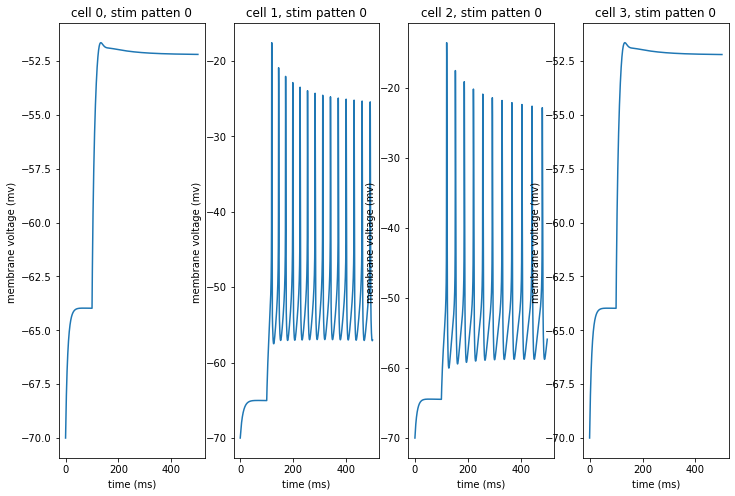

In [10]:
########## Current Injection ##########

h.dt = 0.025
h.celsius = 32
h.tstop = 5000
h.v_init = -70

plt.figure(figsize=(12, 16))
for j, cell in enumerate(cells):
    stim = [h.IClamp(0.5, sec=cell.soma[0]) for i in range(3)]

    stim[0].delay = 100
    stim[0].dur = 1500
    stim[0].amp = 0.01

    stim[1].delay = 1700
    stim[1].dur = 1500
    stim[1].amp = 0.016

    stim[2].delay = 3300
    stim[2].dur = 1500
    stim[2].amp = 0.022

    time = h.Vector()
    time.record(h._ref_t)

    h.finitialize()
    h.run()

    plt.subplot(2, 2, j + 1)
    plt.title(f"cell {j}")
    plt.plot(np.array(time), np.array(cell.vm_soma))
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv) ")


In [ ]:
########## Synaptic Background ##########
h.dt = 0.025
h.celsius = 32
h.tstop = 2500
h.v_init = -70

for cell in cells:
    #number of AMPA syn, NMDA syn, dend number from 0 to 3
    cell.createsyn(1, 1, [0,1], [0,1])

    #Mossy syn
    spk_stim_mossy = []

    for protocol_name, frequency in [('step1', 200), ('step2', 100), ('step3', 50), ('step4', 25), ('step5', 16.6), ('step6', 12.5)]:
        spk_stim = h.NetStim()
        spk_stim.interval = frequency
        spk_stim.number = 1000//frequency
        spk_stim.noise = 0
        spk_stim.start = 100

        spk_stim_2 = h.NetStim()
        spk_stim_2.interval = 10
        spk_stim_2.number = 25
        spk_stim_2.noise = 0
        spk_stim_2.start = 1100

        spk_stim_3 = h.NetStim()
        spk_stim_3.interval = frequency
        spk_stim_3.number = 1000//frequency
        spk_stim_3.noise = 0
        spk_stim_3.start = 1350

        spk_stim_4 = h.NetStim()
        spk_stim_4.interval = 10
        spk_stim_4.number = 25
        spk_stim_4.noise = 0
        spk_stim_4.start = 2350
        
        spk_stim_mossy.append(spk_stim)
        spk_stim_mossy.append(spk_stim_2)
        spk_stim_mossy.append(spk_stim_3)
        spk_stim_mossy.append(spk_stim_4)
        spk_nc_pfsyn = []
        spk_nc_pfsyn_nmda = []

        for m in range(len(spk_stim_mossy)):
            spk_nc_pfsyn.append([h.NetCon(spk_stim_mossy[m],mossy.input,0,0.1,1) for mossy in cell.MF_GrC])
            spk_nc_pfsyn_nmda.append([h.NetCon(spk_stim_mossy[m],mossynmda.input,0,0.1,1) for mossynmda in cell.MF_GrC_mossy])

        time = h.Vector()
        time.record(h._ref_t)

        h.finitialize()
        h.run()

        plt.subplot(2, 2, j + 1)  # TODO: use i
        plt.title(f"cell {j}")  # TODO: use protocol_name
        plt.plot(np.array(time), np.array(cell.vm_soma))
        plt.xlabel("time (ms)")
        plt.ylabel("membrane voltage (mv) ")
